In [1]:
import pandas as pd
import sys, os
import numpy as np
import socket
#from sklearn.linear_model import LinearRegression as LR
import math
import pickle

import itertools

from itertools import combinations,product
from collections import defaultdict, OrderedDict, Counter
import sys, os
import matplotlib
from matplotlib import pyplot as plt
from numba import jit
from scipy import stats, linalg

from tigramite.pcmci import PCMCI
from tigramite.pcmci_base import PCMCIbase
from tigramite import plotting as tp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.independence_tests.oracle_conditional_independence import OracleCI
from tigramite.independence_tests.parcorr import ParCorr
#from tigramite.independence_tests.parcorr_mult import ParCorrMult
from vector_CD.cond_ind_tests.parcorr_mult_regularized import ParCorrMult
from tigramite.independence_tests.pairwise_CI import PairwiseMultCI
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.data_processing import DataFrame
import tigramite.data_processing as pp

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, MultiTaskLassoCV, ElasticNetCV, LassoLarsIC, MultiTaskElasticNetCV
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats import multivariate 

# Function Definitions

## Data Generation

In [13]:
def mult_data_conf(samples, dimxy, dimz, coef, z_int=None, n_conf = 'high', random_state = None):
    
    if random_state is None:
        seed = None
        random_state = np.random.default_rng(seed=seed)
    
    data = random_state.standard_normal((samples, 2*dimxy + dimz))
    confounder = random_state.standard_normal((samples, 1))
    
    if z_int: #z_int denotes how dense z is internally connected (None implies unconnected)
        
        if type(z_int) == str:
        
            if z_int == 'high': # z is fully connected 
                data[:,int(2*dimxy):] += confounder

            elif z_int == 'low': # num_int components of z are connected
                num_int = int(dimz/3)    
                data[:,int(2*dimxy):int(2*dimxy)+num_int] += confounder
            
        elif type(z_int) == int: # z_int components of z are connected
            data[:,int(2*dimxy):int(2*dimxy)+z_int] += confounder
        
    if n_conf == 'high':
        n_conf = dimz  # all components of z act as confounders
    elif n_conf == 'low':
        if dimz>2:
            n_conf = int(dimz/3) # n_conf components of z act as confounders
        elif dimz>0:
            n_conf = 1
        else:
            raise ValueError('dim_z should be greater than zero to generate confounder data')
    else:
        raise ValueError('n_conf should be in ["high", "low"]')
    
    data[:,0:dimxy] += data[:,int(2*dimxy):int(2*dimxy+n_conf)].mean(axis=1).reshape(samples, 1) # Z causes X
    data[:,dimxy:int(2*dimxy)] += data[:,int(2*dimxy):int(2*dimxy)+n_conf].mean(axis=1).reshape(samples, 1) # Z causes Y
    data[:,dimxy:int(2*dimxy)] += coef*data[:,0:dimxy] # X causes Y
    
    return data

In [3]:
## Example
# dimxy = 1
# dimz = 1
# samples = 100
# coef = 0.2
# z_int = None
# n_conf = 'high'
# data = mult_data_conf(samples, dimxy, dimz, coef , z_int, n_conf)
# data.shape

### Functions for Box-M test

In [4]:
def lin_reg(Z,Y):
    model = LinearRegression().fit(Z,Y)
    pred = model.predict(Z)
    resid = Y-pred
    return resid

def boxm(X,Y,Z,samples):
    ZX = np.hstack((X, Z))
    resid_1 = lin_reg(Z,Y)
    resid_2 = lin_reg(ZX,Y)
    cov_1 = np.cov(resid_1)
    cov_2 = np.cov(resid_2)
    
    cov_list = list([cov_1,cov_2])
    nob_list= list([samples,samples])
    boxm = multivariate.test_cov_oneway(cov_list, nob_list)
    
    return boxm.pvalue

## Rate Computation

In [40]:
def error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int=None, n_conf = None, alpha=0.05):
    
    if error == "type1":
        coef = 0.0
    else:
        coef = 0.2 #0.06
        
    pvals = np.zeros(realizations)
    rate = np.zeros(realizations)
    seed = None
    random_state = np.random.default_rng(seed=seed)
    
    for i in range(realizations):
        
        data = mult_data_conf(samples, dimxy, dimz, coef , z_int, n_conf, random_state)
        
        
        dataframe = DataFrame(data, 
            vector_vars={0:[(i,0) for i in range(dimxy)], 
                         1:[(j,0) for j in range(dimxy, 2*dimxy)], 
                         2:[(k, 0) for k in range(2*dimxy, 2*dimxy+dimz)]}
                              )

        cmi.set_dataframe(dataframe)

        pvals[i] = cmi.run_test(
                X=[(0,0)], 
                Y=[(1,0)], 
                Z = [(2, 0)]
                )[1]
        
        rate[i] = pvals[i] <= alpha
        
    ## Bootstrap-based error
    boot_samples = 1000
    boots = np.zeros((boot_samples))
    for b in range(boot_samples):
        rand = np.random.randint(0, realizations, realizations)
        boots[b] = (pvals[rand] <= alpha).mean()
    rate_error = boots.std()

    print(rate.mean(),rate_error)
    return rate.mean(), rate_error


In [41]:
def metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, n_conf = None):

    metrics_nconf =  {y:{x: dict() for x in corr_type_range} for y in reg_range}
    
    for samples in sample_range:
        for corr_type in corr_type_range:
            
            if corr_type == 'boxm':
                print(samples,'ols',corr_type)
                if error == "type1":
                    coef = 0.0
                else:
                    coef = 0.2
                rate_boxm = np.zeros(realizations)
                pvals_boxm = np.zeros(realizations)
                alpha_box = 0.05
                for r in range(realizations):
                    seed = None
                    random_state = np.random.default_rng(seed=seed)
                    data = mult_data_conf(samples, dimxy, dimz, coef , z_int, n_conf, random_state)
                    X = data[:,0:dimxy]#.reshape(samples,1)
                    Y = data[:,dimxy:int(2*dimxy)]#.reshape(samples,1)
                    Z = data[:,int(2*dimxy):]
                    pvals_boxm[r] = boxm(X,Y,Z,samples)
                    rate_boxm[r] = pvals_boxm[r] <= alpha_box
                    boot_samples = 1000
                    boots = np.zeros((boot_samples))
                    for b in range(boot_samples):
                        rand = np.random.randint(0, realizations, realizations)
                        boots[b] = (pvals_boxm[rand] <= alpha_box).mean()
                    rate_error = boots.std()
                    
                metrics_nconf['ols'][corr_type][samples] = (rate_boxm.mean(), rate_error)
                
                print(rate_boxm.mean(), rate_error)
                print('-----------------------')
                
            else:           
            
                for regr in reg_range:

                    if regr == 'ols':
                        reg = LinearRegression()
                    elif regr == 'ridge':
                        reg = RidgeCV()
                    elif regr == 'pls':
                        reg = PLSRegression(n_components=2)
                    else:
                        raise ValueError("Unknown regression type")

                    if 'max_corr' in corr_type:
                        if 'shuffle' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'max_corr',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)
                        else:
                            cmi = ParCorrMult(
                                    correlation_type = 'max_corr',
                                    regularization_model = reg)

                    elif 'gcm' in corr_type:
                        if 'shuffle' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'gcm',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)
                        elif 'gmb' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'gcm_gmb',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)
                        else:
                            cmi = ParCorrMult(
                                    correlation_type = 'gcm',
                                    regularization_model = reg)


                    elif 'linear_hsic' in corr_type:
                        if 'approx' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'linear_hsic_approx',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=1000)
                        elif 'kci' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'linear_hsic_shuffle_kci',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=1000)
                        else:
                            cmi = ParCorrMult(
                                    correlation_type = 'linear_hsic_shuffle',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)

                    print(samples,reg,corr_type)
                    metrics_nconf[regr][corr_type][samples] = error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int, n_conf)
                    print('-----------------------')

    return metrics_nconf


## Example

### Error Rate

In [31]:
dimxy = 20
dimz = 20
samples = 500
realizations = 100#500
n_conf = 'low'
z_int = 'high'

cmi = ParCorrMult(
        correlation_type = 'linear_hsic_shuffle_kci',
        regularization_model = LinearRegression(),            # 0.66
        # regularization_model = RidgeCV(),                      # 0.68
        #regularization_model = MultiTaskLassoCV(),             # 0.722
        #regularization_model = MultiTaskElasticNetCV(),        # 0.77
        # regularization_model = PLSRegression(n_components=1), # 0.95  0.69  0.78  0.64 0.68
        significance = 'shuffle_test',
        sig_blocklength=1,
        sig_samples=1000,
        # verbosity=5,
    )

In [32]:
error = 'power'#'type2'
error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int, n_conf)

0.52 0.05102734560997662


(0.52, 0.05102734560997662)

In [33]:
error = 'type1'
error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int, n_conf)

0.13 0.03370659282692334


(0.13, 0.03370659282692334)

### Metrics for a range of parameters

In [20]:
dimxy = 1
dimz = 1
realizations = 500
sample_range = [100]#, 200, 500]
corr_type_range = ['max_corr']#,'gcm','gcm_gmb','linear_hsic_shuffle_kci']#'linear_hsic_approx' ,'boxm']
reg_range = ['ols']#,'ridge','pls']
z_int = 'high'
n_conf = 'low'

error = 'type1'

In [85]:
metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, n_conf)

100 LinearRegression() max_corr
0.052 0.010217000538318475
-----------------------


{'ols': {'max_corr': {100: (0.052, 0.010217000538318475)}}}

## Dump and retrieve metrics

In [22]:
folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/'

def dump_metrics(conf, results_dict):
    # file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/only_ols/%s' %(conf)
    file_name = folder_name+conf
    print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
    file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
    #pickle.dump(metrics, file, protocol=-1)        
    pickle.dump(results_dict, file, protocol=-1)        
    file.close()
    

def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    #print(name_string)
    name_string = name_string[:-1]
    #print(name_string% (para_setup))

    try:
        print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

def get_results_from_para(para_setup):
    para_setup_str = tuple(para_setup.split("-"))
    results = get_metrics_from_file(para_setup_str)
    return results    

## Plotting function

In [117]:
def color_picker(corr_type):
    if 'max_corr' in corr_type:
        return 'red'
    elif 'gcm' in corr_type:
            return'royalblue'
    elif 'hsic' in corr_type:
        return 'mediumseagreen'#'darkslategray'#'darkorange' 
        # elif 'dep' in score_type:
        #     return 'darkred'

# FOR One regression type and different z_int and n_conf

def gen_plots_zint_nconf(para_setup_list, save  = 'no'):
        
    fig, (axs) = plt.subplots(2, 3, figsize=(12,  6))#, layout="constrained")
    axs = axs.ravel()

    for i,para_setup in enumerate(para_setup_list):
                
        para_setup_string = para_setup
        paras = para_setup_string.split('-') #para_setup_string[0].split('-')
        paras = [w.replace("'","") for w in paras]

        dimxy = int(paras[0])
        dimz = int(paras[1])
        err_type = str(paras[2])
        z_int = str(paras[3])
        n_conf = str(paras[4])  
        
        results = get_results_from_para(para_setup)
        

        for reg_type in results.keys():
            
            fig.suptitle((dimxy,dimz, reg_type))       
            axs[i].title.set_text(para_setup)
            
            for corr_type in results[reg_type].keys():
                if corr_type!='boxm':
                                
                    x = list(results[reg_type][corr_type].keys())
                    sample_range_ticks = [str(m) for m in x]
                    y_tot = np.array([results[reg_type][corr_type][sample_size] for sample_size in x])
                    y = y_tot[:,0]
                    std_error = y_tot[:,1]            
                    x = np.arange(0,len(x),1)


                    axs[i].errorbar(x, y, yerr=std_error, label = corr_type, marker = 'o',color = color_picker(corr_type))
                    axs[i].set_xlabel('sample size')
                    if err_type == 'type1':
                        axs[i].set_ylabel(err_type+' error')
                    else:
                        axs[i].set_ylabel('power')
                    axs[i].tick_params(axis='y')
                    axs[i].grid(True)
                    axs[i].set_title(('z_int='+z_int,'n_conf='+n_conf))

                    if err_type == 'type1':
                        axs[i].set_ylim(-0.01, 1.0)
                        axs[i].axhline(y=0.05, color='black', linestyle='dotted')
                    else:
                        axs[i].set_ylim(-0.05, 1.15)
                    

                    axs[i].xaxis.set_ticks(list(x) )
                    axs[i].xaxis.set_ticklabels(sample_range_ticks)

                
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()
    
    # new_name = str(dimxy)+'-'+str(dimz)+'-ols'
    # print(para_setup, '\n-------\n',new_name)
    # print(type(para_setup))
    # print(type(new_name))

    if save == 'yes':
        save_suffix = str(dimxy)+'-'+str(dimz)+'-'+err_type+'-ols-0.06' #para_setup
        save_type = 'pdf'
        save_folder = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/local_figures/only_ols_final/'
        fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type))

# New Experiments (only OLS)

## Example

In [35]:
dimxy = 1
dimz = 20
realizations = 100 #500
sample_range = [100]#, 200, 500]
corr_type_range = ['max_corr','gcm','linear_hsic_shuffle_kci']#'linear_hsic_approx','gcm_gmb' ,'boxm']
reg_range = ['ols']#,'ridge','pls']
z_int = 'high'
n_conf = 'high'
error = 'type1'

para_setup = (dimxy,dimz,error,z_int,n_conf)
conf = '%s-'*len(para_setup) % para_setup
conf = conf[:-1]

In [36]:
metrics_1_20_high_high_type1 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, n_conf)
results_dict = metrics_1_20_high_high_type1
dump_metrics(conf,results_dict)

100 LinearRegression() max_corr
0.02 0.01474730822896165
-----------------------
100 LinearRegression() gcm
0.1 0.02858845746101038
-----------------------
100 LinearRegression() linear_hsic_shuffle_kci
0.11 0.030098702629847686
-----------------------
Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/1-20-type1-high-high_metrics.dat


In [38]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)
if results == results_dict:
    print('Metric dump happened correctly')
else:
    print('CHECK!')

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/1-20-type1-high-high_metrics.dat 
Metric dump happened correctly


## Experiments

In [83]:
realizations = 500
sample_range = [100, 200, 300, 500]
corr_type_range = ['max_corr','gcm_gmb','linear_hsic_shuffle_kci']#,'boxm']#'linear_hsic_approx','gcm_gmb' ,'boxm']
reg_range = ['ols']

for dimxy in [5,20]:
    for dimz in [20]:
        for z_int in [None, 'low', 'high']:
            for n_conf in ['low','high']:
                for error in ['type1', 'type2']:
                    para_setup = (dimxy,dimz,error,z_int,n_conf)
                    conf = '%s-'*len(para_setup) % para_setup
                    conf = conf[:-1]
                    
                    # conf = conf+'-0.06'
                    
                    print('====================\n',conf,'\n====================')
                    
                    results_dict = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, n_conf)
                    dump_metrics(conf,results_dict)
                    
                    # para_setup = tuple(conf.split("-"))
                    # results = get_metrics_from_file(para_setup)
                    # if results == results_dict:
                    #     print('Metric dump happened correctly')
                    # else:
                    #     print('CHECK!',conf)
                 
            

 5-20-type1-None-low 
100 LinearRegression() max_corr
0.032 0.0077788626418005356
-----------------------
100 LinearRegression() gcm_gmb
0.088 0.012380740527125187
-----------------------
100 LinearRegression() linear_hsic_shuffle_kci
0.224 0.017966640643147513
-----------------------
200 LinearRegression() max_corr
0.05 0.009949285602494282
-----------------------
200 LinearRegression() gcm_gmb
0.074 0.01147483768948389
-----------------------
200 LinearRegression() linear_hsic_shuffle_kci
0.098 0.013002500682561029
-----------------------
300 LinearRegression() max_corr
0.066 0.011284296344921115
-----------------------
300 LinearRegression() gcm_gmb
0.066 0.011458708478707362
-----------------------
300 LinearRegression() linear_hsic_shuffle_kci
0.06 0.010444538477118077
-----------------------
500 LinearRegression() max_corr
0.048 0.009295331946735414
-----------------------
500 LinearRegression() gcm_gmb
0.06 0.010445325078713444
-----------------------
500 LinearRegression() line

## Plots

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-None-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-low-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-high-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-None-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-low-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-high-high_metrics.dat 


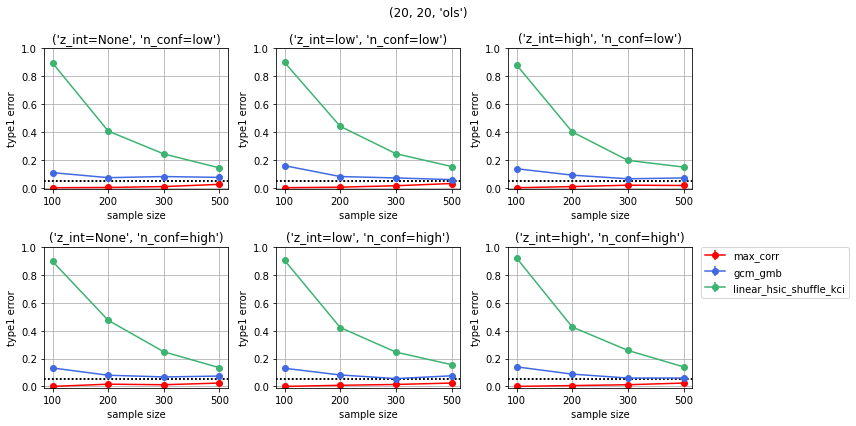

In [118]:
anyconfigurations = [] 
for dimxy in [20]:
    for dimz in [20]:
        for err_type in ['type1']:
            for n_conf in ['low','high']:
                for z_int in [None, 'low', 'high']:

                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    # para_setup = (dimxy,dimz,err_type,z_int,n_conf,0.06)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

# anyconfigurations
gen_plots_zint_nconf(anyconfigurations, save = 'no')

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-None-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-low-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-high-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-None-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-low-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-high-high_metrics.dat 


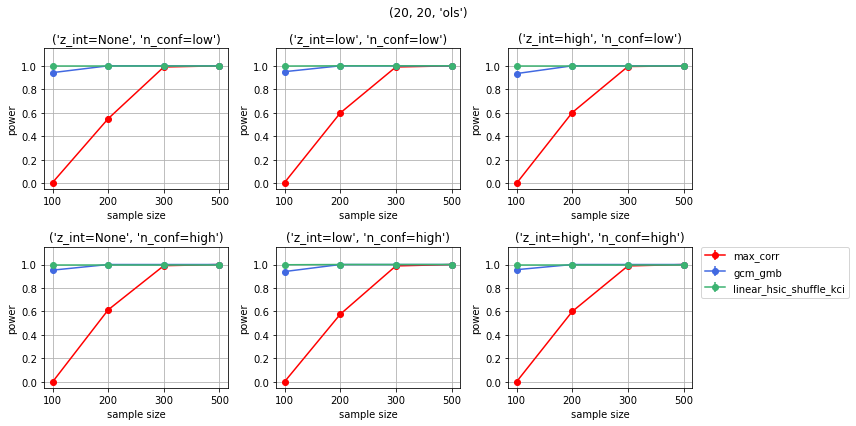

In [115]:
anyconfigurations = [] 
for dimxy in [20]:
    for dimz in [20]:
        for err_type in ['type2']:
            for n_conf in ['low','high']:
                for z_int in [None, 'low', 'high']:

                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    # para_setup = (dimxy,dimz,err_type,z_int,n_conf,0.06)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

# anyconfigurations
gen_plots_zint_nconf(anyconfigurations, save = 'no')

Following are old experiments for general regression types (OLS, PLS, Ridge etc)

# Case 1: Univariate X,Y ; Multivariate Z

## (i) n_conf = Full (i.e. all Z components act as confounders)

### Type 1

#### 1-20

In [105]:
dimxy = 1
dimz = 20
realizations = 500
#z_int = None
#n_conf = 5

In [106]:
corr_type_range = ['max_corr','max_corr_shuffle','gcm','gcm_shuffle','gcm_gmb']
reg_range = ['ols','ridge','pls']

In [107]:
metrics =  {y:{x: dict() for x in corr_type_range} for y in reg_range}
# for samples in [100,1000,5000]:
#     for corr_type in corr_type_range:
#         for reg in reg_range:
#             metrics[reg][corr_type][samples] = 'mean','error'

In [109]:
for samples in [100,1000,5000]:
    for corr_type in corr_type_range:
        for regr in reg_range:
            
            if regr == 'ols':
                reg = LinearRegression()
            elif regr == 'ridge':
                reg = RidgeCV()
            elif regr == 'pls':
                reg = PLSRegression(n_components=1)
            else:
                raise ValueError("Unknown regression type")
            
            if 'max_corr' in corr_type:
                if 'shuffle' in corr_type:
                    cmi = ParCorrMult(
                            correlation_type = 'max_corr',
                            regularization_model = reg,
                            significance = 'shuffle_test',
                            sig_blocklength=1,
                            sig_samples=200)
                else:
                    cmi = ParCorrMult(
                            correlation_type = 'max_corr',
                            regularization_model = reg)
                    
            elif 'gcm' in corr_type:
                if 'shuffle' in corr_type:
                    cmi = ParCorrMult(
                            correlation_type = 'gcm',
                            regularization_model = reg,
                            significance = 'shuffle_test',
                            sig_blocklength=1,
                            sig_samples=200)
                elif 'gmb' in corr_type:
                    cmi = ParCorrMult(
                            correlation_type = 'gcm_gmb',
                            regularization_model = reg,
                            significance = 'shuffle_test',
                            sig_blocklength=1,
                            sig_samples=200)
                else:
                    cmi = ParCorrMult(
                            correlation_type = 'gcm',
                            regularization_model = reg)
                    
                    
            error = 'type1'
            print(samples,reg,corr_type)
            metrics[regr][corr_type][samples] = error_rate(error, cmi, realizations, samples, dimxy, dimz)
            print('-----------------------')
            

100 LinearRegression() max_corr
0.05 0.00998749217771909
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.044 0.009144501954726676
-----------------------
100 PLSRegression(n_components=1) max_corr
0.058 0.010332078009771317
-----------------------
100 LinearRegression() max_corr_shuffle
0.072 0.011091816803391589
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.042 0.008886028359171492
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle
0.07 0.011921864115984546
-----------------------
100 LinearRegression() gcm
0.068 0.01116697344852221
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm
0.096 0.013251895562522367
-----------------------
100 PLSRegression(n_components=1) gcm
0.064 0.010632854743670676
-----------------------
100 LinearRegression() gcm_shuffle
0.028 0.007527221001139796
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.

#### 1-50

In [226]:
dimxy = 1
dimz = 50
realizations = 500
sample_range = [100, 500, 1000]
corr_type_range = ['max_corr','max_corr_shuffle','gcm','gcm_shuffle']#,'gcm_gmb']
reg_range = ['ols','ridge','pls']

error = 'type1'

In [227]:
metrics_1_50_type1 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, num_int = None, n_conf = None)

100 LinearRegression() max_corr
0.056 0.010510899295493226
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.046 0.009071185148590013
-----------------------
100 PLSRegression(n_components=1) max_corr
0.014 0.005341219336443693
-----------------------
100 LinearRegression() max_corr_shuffle
0.046 0.009351171049660038
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.054 0.00999617506849495
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle
0.06 0.010650218964885182
-----------------------
100 LinearRegression() gcm
0.162 0.016416088571885812
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm
0.146 0.0153302712304773
-----------------------
100 PLSRegression(n_components=1) gcm
0.09 0.012385852574611084
-----------------------
100 LinearRegression() gcm_shuffle
0.02 0.006096884122238178
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.03

In [230]:
metrics_1_50_type1

{'ols': {'max_corr': {100: (0.056, 0.010510899295493226),
   500: (0.046, 0.009279641372380723),
   1000: (0.046, 0.00930967238950974)},
  'max_corr_shuffle': {100: (0.046, 0.009351171049660038),
   500: (0.068, 0.011220512466015088),
   1000: (0.048, 0.00938170048551967)},
  'gcm': {100: (0.162, 0.016416088571885812),
   500: (0.068, 0.011230603901838937),
   1000: (0.052, 0.009735689189780045)},
  'gcm_shuffle': {100: (0.02, 0.006096884122238178),
   500: (0.036, 0.008272328813580854),
   1000: (0.028, 0.00723999889502754)}},
 'ridge': {'max_corr': {100: (0.046, 0.009071185148590013),
   500: (0.038, 0.008310094102956958),
   1000: (0.052, 0.009947525521455072)},
  'max_corr_shuffle': {100: (0.054, 0.00999617506849495),
   500: (0.064, 0.01075996115234623),
   1000: (0.058, 0.010684523199469408)},
  'gcm': {100: (0.146, 0.0153302712304773),
   500: (0.06, 0.010768017644859244),
   1000: (0.082, 0.012198777643682173)},
  'gcm_shuffle': {100: (0.032, 0.007512185034994812),
   500: (0.0

#### 1-20 (z_int = High)

In [76]:
dimxy = 1
dimz = 20
realizations = 500
sample_range = [100, 200, 500]
corr_type_range = ['max_corr','max_corr_shuffle','gcm','gcm_shuffle']#,'gcm_gmb']
reg_range = ['ols','ridge','pls']
z_int = 'high'

error = 'type1'

In [77]:
metrics_1_20_type1_high = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, num_int = None, n_conf = None)

100 LinearRegression() max_corr
0.054 0.00982241497799803
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.066 0.011127821709571016
-----------------------
100 PLSRegression(n_components=1) max_corr
0.03 0.0076558693823758515
-----------------------
100 LinearRegression() max_corr_shuffle
0.04 0.008674416637446003
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.054 0.009901631380737219
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle
0.058 0.010107403227337872
-----------------------
100 LinearRegression() gcm
0.098 0.013118071657069113
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm
0.08 0.011926438529586273
-----------------------
100 PLSRegression(n_components=1) gcm
0.066 0.010783281689726925
-----------------------
100 LinearRegression() gcm_shuffle
0.026 0.00694712717603471
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.

In [79]:
conf = "1-20-type1-high-None"
file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/%s' %(conf)

print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')     
pickle.dump(metrics_1_20_type1_high, file, protocol=-1)        
file.close()

Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type1-high-None_metrics.dat


In [80]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type1-high-None_metrics.dat 


sample range = [100, 200, 500] 
----
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type1-None-5_metrics.dat 


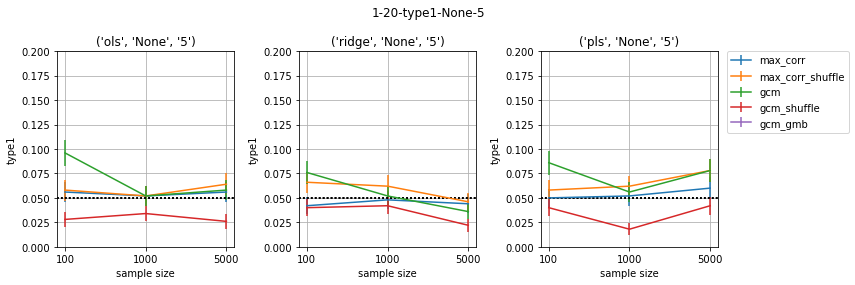

In [92]:
anyconfigurations = [] 
for dimxy in [1]:
    for dimz in [20]:
        for err_type in ['type1']:
            for z_int in ['None']:
                for n_conf in ['5']:
                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

#anyconfigurations[0]
gen_plots_sample_size(anyconfigurations, save = 'yes')

### Type 2

#### 1-20 (z_int = High)

In [83]:
dimxy = 1
dimz = 20
realizations = 500
z_int = 'high'
#n_conf = 5
sample_range = [100,200,500]
corr_type_range = ['max_corr','max_corr_shuffle','gcm','gcm_shuffle']#,'gcm_gmb']
reg_range = ['ols','ridge','pls']

error = 'type2'

In [84]:
metrics_1_20_type2_high = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, num_int = None, n_conf = None)

100 LinearRegression() max_corr
0.726 0.02018259487776536
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.742 0.018269512965593815
-----------------------
100 PLSRegression(n_components=1) max_corr
0.754 0.019647534196432913
-----------------------
100 LinearRegression() max_corr_shuffle
0.766 0.01916133440029688
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.786 0.018771748560003677
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle
0.794 0.018873897318783944
-----------------------
100 LinearRegression() gcm
0.82 0.016480263954196824
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm
0.792 0.017817073946077674
-----------------------
100 PLSRegression(n_components=1) gcm
0.846 0.015841076226064954
-----------------------
100 LinearRegression() gcm_shuffle
0.642 0.02151219189204114
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.

In [85]:
conf = "1-20-type2-high-None"
file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/%s' %(conf)

print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')     
pickle.dump(metrics_1_20_type2_high, file, protocol=-1)        
file.close()

Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type2-high-None_metrics.dat


In [86]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type2-high-None_metrics.dat 


sample range = [100, 200, 500] 
----
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type2-None-5_metrics.dat 


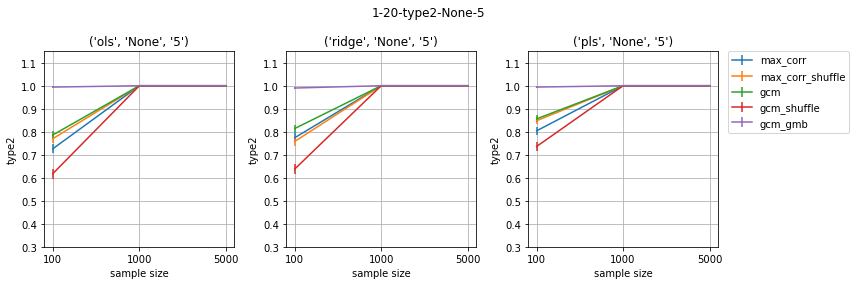

In [93]:
anyconfigurations = [] 
for dimxy in [1]:
    for dimz in [20]:
        for err_type in ['type2']:
            for z_int in ['None']:
                for n_conf in ['5']:
                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

#anyconfigurations[0]
gen_plots_sample_size(anyconfigurations, save = 'yes')

#### 1-50

In [228]:
dimxy = 1
dimz = 50
realizations = 500
sample_range = [100, 500, 1000]
corr_type_range = ['max_corr','max_corr_shuffle','gcm','gcm_shuffle']#,'gcm_gmb']
reg_range = ['ols','ridge','pls']

error = 'type2'

In [229]:
metrics_1_50_type2 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, num_int = None, n_conf = None)

100 LinearRegression() max_corr
0.594 0.021907660395395948
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.514 0.022659941659236474
-----------------------
100 PLSRegression(n_components=1) max_corr
0.544 0.022650580478212903
-----------------------
100 LinearRegression() max_corr_shuffle
0.564 0.022267490563599637
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.592 0.022674260649467717
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle
0.744 0.019389725526680376
-----------------------
100 LinearRegression() gcm
0.772 0.018224322099875224
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm
0.714 0.02053456948659991
-----------------------
100 PLSRegression(n_components=1) gcm
0.81 0.01720623142933975
-----------------------
100 LinearRegression() gcm_shuffle
0.396 0.021254748081311146
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0

In [231]:
metrics_1_50_type2

{'ols': {'max_corr': {100: (0.594, 0.021907660395395948),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.564, 0.022267490563599637),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm': {100: (0.772, 0.018224322099875224),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.396, 0.021254748081311146),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)}},
 'ridge': {'max_corr': {100: (0.514, 0.022659941659236474),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.592, 0.022674260649467717),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm': {100: (0.714, 0.02053456948659991),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.46, 0.021799997706421898),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)}},
 'pls': {'max_corr': {100: (0.544, 0.022650580478212903),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.744, 0.019389725526680376),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm': {100: (0.81, 0.017

### Dump Metrics

In [235]:
#conf = "1-20-type1-None-None"
conf = "1-50-type2-None-None"
file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/%s' %(conf)

print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
#pickle.dump(metrics, file, protocol=-1)        
pickle.dump(metrics_1_50_type2, file, protocol=-1)        
file.close()

Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-50-type2-None-None_metrics.dat


In [236]:
folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/'
def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    #print(name_string)
    name_string = name_string[:-1]
    #print(name_string% (para_setup))

    try:
        print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

In [237]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-50-type2-None-None_metrics.dat 


## (ii) n_conf = 5 (i.e. 5 components of Z act as confounders)

In [327]:
dimxy = 1
dimz = 20
realizations = 500
n_conf = 5

In [328]:
corr_type_range = ['max_corr','max_corr_shuffle','gcm','gcm_shuffle','gcm_gmb']
reg_range = ['ols','ridge','pls']
sample_range = [100,1000,5000]

### Type 1

In [112]:
metrics_nconf =  {y:{x: dict() for x in corr_type_range} for y in reg_range}

In [117]:
def metrics_rate(sample_range,corr_type_range,reg_range,error = 'type1'):

    for samples in sample_range:
        for corr_type in corr_type_range:
            for regr in reg_range:

                if regr == 'ols':
                    reg = LinearRegression()
                elif regr == 'ridge':
                    reg = RidgeCV()
                elif regr == 'pls':
                    reg = PLSRegression(n_components=1)
                else:
                    raise ValueError("Unknown regression type")

                if 'max_corr' in corr_type:
                    if 'shuffle' in corr_type:
                        cmi = ParCorrMult(
                                correlation_type = 'max_corr',
                                regularization_model = reg,
                                significance = 'shuffle_test',
                                sig_blocklength=1,
                                sig_samples=200)
                    else:
                        cmi = ParCorrMult(
                                correlation_type = 'max_corr',
                                regularization_model = reg)

                elif 'gcm' in corr_type:
                    if 'shuffle' in corr_type:
                        cmi = ParCorrMult(
                                correlation_type = 'gcm',
                                regularization_model = reg,
                                significance = 'shuffle_test',
                                sig_blocklength=1,
                                sig_samples=200)
                    elif 'gmb' in corr_type:
                        cmi = ParCorrMult(
                                correlation_type = 'gcm_gmb',
                                regularization_model = reg,
                                significance = 'shuffle_test',
                                sig_blocklength=1,
                                sig_samples=200)
                    else:
                        cmi = ParCorrMult(
                                correlation_type = 'gcm',
                                regularization_model = reg)

                print(samples,reg,corr_type)
                metrics_nconf[regr][corr_type][samples] = error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int=None, num_int = None, n_conf = n_conf)
                print('-----------------------')
                
    return metrics_nconf


In [118]:
metrics_nconf_5 = metrics_rate(sample_range,corr_type_range,reg_range)

100 LinearRegression() max_corr
0.056 0.010079647612888062
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.042 0.00859404072599147
-----------------------
100 PLSRegression(n_components=1) max_corr
0.05 0.009448653660707436
-----------------------
100 LinearRegression() max_corr_shuffle
0.058 0.010713558512464475
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.066 0.010948303247535665
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle
0.058 0.010458771629593985
-----------------------
100 LinearRegression() gcm
0.096 0.013419537845991567
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm
0.076 0.011835728283464436
-----------------------
100 PLSRegression(n_components=1) gcm
0.086 0.012458372124800254
-----------------------
100 LinearRegression() gcm_shuffle
0.028 0.007274608992928761
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle


### Type 2

In [330]:
error = 'type2'
n_conf = 5

In [334]:
metrics_nconf_5_type2 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, num_int = None, n_conf = n_conf)

100 LinearRegression() max_corr
0.726 0.0191562000407179
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.774 0.018903129793766967
-----------------------
100 PLSRegression(n_components=1) max_corr
0.804 0.017357289074046073
-----------------------
100 LinearRegression() max_corr_shuffle
0.77 0.018413076983491938
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.758 0.01930554645691234
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle
0.848 0.016098525522543993
-----------------------
100 LinearRegression() gcm
0.786 0.01864881240186624
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm
0.814 0.017433526206708697
-----------------------
100 PLSRegression(n_components=1) gcm
0.856 0.014638729453063897
-----------------------
100 LinearRegression() gcm_shuffle
0.618 0.02206646541700779
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.63

In [335]:
metrics_nconf_5_type2

{'ols': {'max_corr': {100: (0.726, 0.0191562000407179),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.77, 0.018413076983491938),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm': {100: (0.786, 0.01864881240186624),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.618, 0.02206646541700779),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_gmb': {100: (0.994, 0.003466262540547098),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)}},
 'ridge': {'max_corr': {100: (0.774, 0.018903129793766967),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.758, 0.01930554645691234),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm': {100: (0.814, 0.017433526206708697),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.638, 0.020959272411035665),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_gmb': {100: (0.99, 0.004352463210642915),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)}},
 'pls': {'max_corr': {100: (0.804, 0.01

### Dump Metrics

In [338]:
#conf = "1-20-type1-None-5"
conf = "1-20-type2-None-5"
file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/%s' %(conf)

print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
#pickle.dump(metrics_nconf_5, file, protocol=-1)        
pickle.dump(metrics_nconf_5_type2, file, protocol=-1)        
file.close()

Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type2-None-5_metrics.dat


In [339]:
folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/'
def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    #print(name_string)
    name_string = name_string[:-1]
    #print(name_string% (para_setup))

    try:
        print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

In [340]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type2-None-5_metrics.dat 


In [341]:
results

{'ols': {'max_corr': {100: (0.726, 0.0191562000407179),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.77, 0.018413076983491938),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm': {100: (0.786, 0.01864881240186624),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.618, 0.02206646541700779),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_gmb': {100: (0.994, 0.003466262540547098),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)}},
 'ridge': {'max_corr': {100: (0.774, 0.018903129793766967),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.758, 0.01930554645691234),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm': {100: (0.814, 0.017433526206708697),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.638, 0.020959272411035665),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)},
  'gcm_gmb': {100: (0.99, 0.004352463210642915),
   1000: (1.0, 0.0),
   5000: (1.0, 0.0)}},
 'pls': {'max_corr': {100: (0.804, 0.01

# Case 2 (Multivariate X,Y,Z)

## (i) n_conf  = Full

### Type 1

In [22]:
dimxy = 10
dimz = 20
realizations = 500

sample_range = [100,200,500, 1000]
corr_type_range = ['max_corr','max_corr_shuffle','gcm_shuffle','gcm_gmb']
reg_range = ['ols','ridge','pls']

error = 'type1'

In [23]:
metrics_10_20_type1 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, num_int = None, n_conf = None)

100 LinearRegression() max_corr
0.006 0.003539717502852452
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.0 0.0
-----------------------
100 PLSRegression(n_components=1) max_corr
0.002 0.0018712295423063414
-----------------------
100 LinearRegression() max_corr_shuffle
0.084 0.012404176715929196
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.084 0.012352113341448902
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

0.072 0.011056080860775214
-----------------------
100 LinearRegression() gcm_shuffle
0.012 0.004763641884105059
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.034 0.008147242723768575
-----------------------
100 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.03 0.0077167285814650766
-----------------------
100 LinearRegression() gcm_gmb
0.086 0.012497108625598163
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.092 0.012537740785324923
-----------------------
100 PLSRegression(n_components=1) gcm_gmb
0.054 0.010071599475753592
-----------------------
200 LinearRegression() max_corr
0.016 0.005543563835656625
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.022 0.006391212717473891
-----------------------
200 PLSRegression(n_components=1) max_corr
0.016 0.005532079175138403
-----------------------
200 LinearRegression() max_corr_shuffle
0.056 0.01047211229886311
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.052 0.00967671927876385
-----------------------
200 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

0.07 0.01116402633461602
-----------------------
200 LinearRegression() gcm_shuffle
0.034 0.008466830339625331
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.036 0.007815512523181061
-----------------------
200 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.032 0.007900521248626573
-----------------------
200 LinearRegression() gcm_gmb
0.06 0.010516758245771364
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.086 0.01280433660913364
-----------------------
200 PLSRegression(n_components=1) gcm_gmb
0.04 0.008875954934540846
-----------------------
500 LinearRegression() max_corr
0.034 0.008205601745149468
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.038 0.008566156430978833
-----------------------
500 PLSRegression(n_components=1) max_corr
0.04 0.008380174461191128
-----------------------
500 LinearRegression() max_corr_shuffle
0.054 0.010037111138171182
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.048 0.009647581251277442
-----------------------
500 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

0.048 0.009905548949957292
-----------------------
500 LinearRegression() gcm_shuffle
0.024 0.006735933194443069
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.028 0.007250043861936285
-----------------------
500 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

0.048 0.009345251414488538
-----------------------
500 LinearRegression() gcm_gmb
0.068 0.010985013609459025
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.068 0.010831413388842658
-----------------------
500 PLSRegression(n_components=1) gcm_gmb
0.034 0.008022617777259492
-----------------------
1000 LinearRegression() max_corr
0.028 0.007377777443105749
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.036 0.008369983512528564
-----------------------
1000 PLSRegression(n_components=1) max_corr
0.044 0.009145969822823603
-----------------------
1000 LinearRegression() max_corr_shuffle
0.042 0.009192683830090101
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.084 0.012589038883091909
-----------------------
1000 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.054 0.009788358595801443
-----------------------
1000 LinearRegression() gcm_shuffle
0.03 0.007625326222529761
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.032 0.008014722453085946
-----------------------
1000 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.014 0.005273770567629957
-----------------------
1000 LinearRegression() gcm_gmb
0.074 0.011342386168703656
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.032 0.007753770437664505
-----------------------
1000 PLSRegression(n_components=1) gcm_gmb
0.06 0.010642559090745045
-----------------------


In [26]:
metrics_10_20_type1

{'ols': {'max_corr': {100: (0.006, 0.003539717502852452),
   200: (0.016, 0.005543563835656625),
   500: (0.034, 0.008205601745149468),
   1000: (0.028, 0.007377777443105749)},
  'max_corr_shuffle': {100: (0.084, 0.012404176715929196),
   200: (0.056, 0.01047211229886311),
   500: (0.054, 0.010037111138171182),
   1000: (0.042, 0.009192683830090101)},
  'gcm_shuffle': {100: (0.012, 0.004763641884105059),
   200: (0.034, 0.008466830339625331),
   500: (0.024, 0.006735933194443069),
   1000: (0.03, 0.007625326222529761)},
  'gcm_gmb': {100: (0.086, 0.012497108625598163),
   200: (0.06, 0.010516758245771364),
   500: (0.068, 0.010985013609459025),
   1000: (0.074, 0.011342386168703656)}},
 'ridge': {'max_corr': {100: (0.0, 0.0),
   200: (0.022, 0.006391212717473891),
   500: (0.038, 0.008566156430978833),
   1000: (0.036, 0.008369983512528564)},
  'max_corr_shuffle': {100: (0.084, 0.012352113341448902),
   200: (0.052, 0.00967671927876385),
   500: (0.048, 0.009647581251277442),
   1000: 

### Dump Metrics

In [27]:
#conf = "1-20-type1-None-None"
# conf = "5-20-type1-None-None"
conf = "10-20-type1-None-None"
file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/%s' %(conf)

print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
#pickle.dump(metrics, file, protocol=-1)

pickle.dump(metrics_10_20_type1, file, protocol=-1)        
file.close()

Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/10-20-type1-None-None_metrics.dat


In [31]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/10-20-type1-None-None_metrics.dat 


### Type 2

In [24]:
dimxy = 10
dimz = 20
realizations = 500

sample_range = [100,200,500, 1000]
corr_type_range = ['max_corr','max_corr_shuffle','gcm_shuffle','gcm_gmb']
reg_range = ['ols','ridge','pls']

error = 'type2'

In [25]:
metrics_10_20_type2 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, num_int = None, n_conf = None)

100 LinearRegression() max_corr
0.556 0.023058662493735383
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.586 0.02095991412196147
-----------------------
100 PLSRegression(n_components=1) max_corr
0.468 0.021402189701056288
-----------------------
100 LinearRegression() max_corr_shuffle
0.892 0.014128538494833793
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.85 0.015308235561291848
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

0.98 0.006256823155563859
-----------------------
100 LinearRegression() gcm_shuffle
0.966 0.007932713028970612
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.976 0.007051185432251806
-----------------------
100 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.998 0.00207405303693035
-----------------------
100 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.994 0.0035445276130959998
-----------------------
100 PLSRegression(n_components=1) gcm_gmb
0.994 0.0035811500945925213
-----------------------
200 LinearRegression() max_corr
1.0 0.0
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
200 PLSRegression(n_components=1) max_corr
1.0 0.0
-----------------------
200 LinearRegression() max_corr_shuffle
1.0 0.0
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
1.0 0.0
-----------------------
200 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

1.0 0.0
-----------------------
200 LinearRegression() gcm_shuffle
1.0 0.0
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
1.0 0.0
-----------------------
200 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


1.0 0.0
-----------------------
200 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
200 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
200 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
500 LinearRegression() max_corr
1.0 0.0
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
500 PLSRegression(n_components=1) max_corr
1.0 0.0
-----------------------
500 LinearRegression() max_corr_shuffle
1.0 0.0
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
1.0 0.0
-----------------------
500 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

1.0 0.0
-----------------------
500 LinearRegression() gcm_shuffle
1.0 0.0
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
1.0 0.0
-----------------------
500 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


1.0 0.0
-----------------------
500 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
500 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
500 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
1000 LinearRegression() max_corr
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) max_corr
1.0 0.0
-----------------------
1000 LinearRegression() max_corr_shuffle
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


1.0 0.0
-----------------------
1000 LinearRegression() gcm_shuffle
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


1.0 0.0
-----------------------
1000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------


In [33]:
metrics_10_20_type2

{'ols': {'max_corr': {100: (0.556, 0.023058662493735383),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.892, 0.014128538494833793),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.966, 0.007932713028970612),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm_gmb': {100: (1.0, 0.0),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)}},
 'ridge': {'max_corr': {100: (0.586, 0.02095991412196147),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'max_corr_shuffle': {100: (0.85, 0.015308235561291848),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm_shuffle': {100: (0.976, 0.007051185432251806),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)},
  'gcm_gmb': {100: (0.994, 0.0035445276130959998),
   200: (1.0, 0.0),
   500: (1.0, 0.0),
   1000: (1.0, 0.0)}},
 'pls': {'max_corr': {100: (0.468, 0.021402189701056288),
   200: (1.0, 0.0),


### Dump Metrics

In [34]:
#conf = "1-20-type1-None-None"
conf = "10-20-type2-None-None"
file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/%s' %(conf)

print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
#pickle.dump(metrics, file, protocol=-1)        
pickle.dump(metrics_10_20_type2, file, protocol=-1)        
file.close()

Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/10-20-type2-None-None_metrics.dat


In [35]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/10-20-type2-None-None_metrics.dat 


# Plotting function

In [38]:
def gen_plots_sample_size(para_setup_list= anyconfigurations, save  = 'no'):
    
    print('sample range =', sample_range,'\n----')
    
    fig, (axs) = plt.subplots(1, 3, figsize=(12,  4))#, layout="constrained")
    axs = axs.ravel()
    
    l = 0
    for j,para_setup in enumerate(para_setup_list):
        
        #print('j', j)
        
        para_setup_string = para_setup
        paras = para_setup_string.split('-') #para_setup_string[0].split('-')
        paras = [w.replace("'","") for w in paras]

        dimxy = int(paras[0])
        dimz = int(paras[1])
        err_type = str(paras[2])
        z_int = str(paras[3])
        n_conf = str(paras[4])        
        results = get_results_from_para(para_setup)
        
        fig.suptitle(para_setup)
        
        for i,reg_type in enumerate(results.keys()): 
            
            i+=l
            #print('i',i)            
            axs[i].title.set_text(para_setup)
            
            for corr_type in results[reg_type].keys():
                
                # if dimxy == 1 and corr_type != 'gcm_gmb':
                
                x = list(results[reg_type][corr_type].keys())
                sample_range_ticks = [str(m) for m in x]

                y_tot = np.array([results[reg_type][corr_type][sample_size] for sample_size in x])
                y = y_tot[:,0]
                std_error = y_tot[:,1]            
                x = np.arange(0,len(x),1)
                axs[i].errorbar(x, y, yerr=std_error, label = corr_type)
                axs[i].set_xlabel('sample size')
                axs[i].set_ylabel(err_type)
                axs[i].tick_params(axis='y')
                axs[i].grid(True)
                axs[i].set_title((reg_type,z_int,n_conf))

                if err_type == 'type1':
                    axs[i].set_ylim(0.0, 0.2)
                else:
                    axs[i].set_ylim(0.3, 1.15)
                axs[i].axhline(y=0.05, color='black', linestyle='dotted')

                axs[i].xaxis.set_ticks(list(x) )
                axs[i].xaxis.set_ticklabels(sample_range_ticks)
                


                
        l+=3
                
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


        fig.tight_layout()
        
        if save == 'yes':
            save_suffix = para_setup#+'-shd'
            save_type = 'pdf'
            save_folder = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/local_figures/'
            fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type))
    
#     if save == 'yes':
#         save_suffix = para_setup#+'-shd'
#         save_type = 'pdf'
#         save_folder = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/local_figures/'
#         fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type))
        

sample range = [100, 200, 500, 1000] 
----
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/10-20-type1-None-None_metrics.dat 


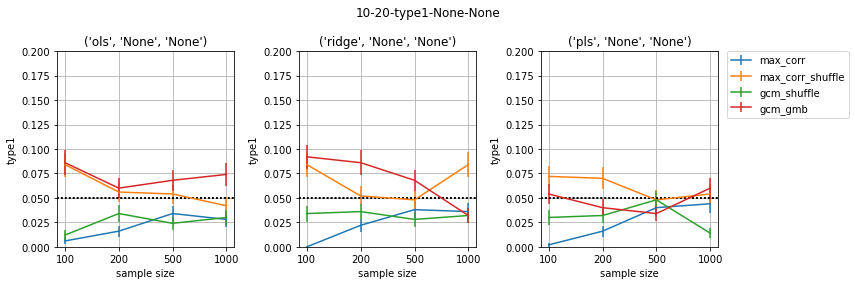

In [39]:
anyconfigurations = [] 
for dimxy in [10]:
    for dimz in [20]:
        for err_type in ['type1']:
            for z_int in ['None']:
                for n_conf in ['None']:
                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

#anyconfigurations[0]
gen_plots_sample_size(anyconfigurations, save = 'yes')

sample range = [100, 200, 500, 1000] 
----
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/10-20-type2-None-None_metrics.dat 


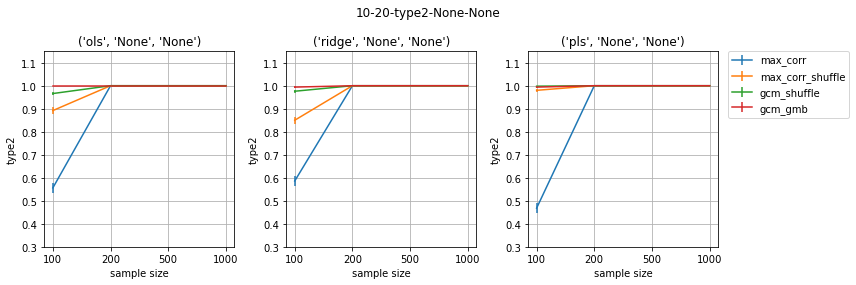

In [40]:
anyconfigurations = [] 
for dimxy in [10]:
    for dimz in [20]:
        for err_type in ['type2']:
            for z_int in ['None']:
                for n_conf in ['None']:
                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

#anyconfigurations
gen_plots_sample_size(anyconfigurations, save = 'yes')

### Try with z_int = 'High', see if power goes down

# Local Plot Script

In [30]:
if os.path.expanduser('~') == '/home/b/b381872':
    folder_name = os.path.expanduser('~') +'/work/bd1083/Interim_results/multCI/metrics/'
    save_folder = os.path.expanduser('~') + '/work/bd1083/Projects/multCI/figures/'
elif os.path.expanduser('~') == '/Users/urmininad':
    #folder_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/Interim_results/'
    # save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
    
    folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/'

def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    name_string = name_string[:-1]

    try:
        print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

def get_results_from_para(para_setup):
    para_setup_str = tuple(para_setup.split("-"))
    results = get_metrics_from_file(para_setup_str)
    return results    

# para_setup = "1-20-type1-None-5"
# results = get_results_from_para(para_setup)

In [29]:
def gen_plots_sample_size(para_setup_list= anyconfigurations):
    
    fig, (axs) = plt.subplots(2, 3, figsize=(12,  6))#, layout="constrained")
    #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.3)
    #plt.xticks([0,100,5000])
    # plt.setp(axs, xticks=[0.1, 0.5, 0.9], xticklabels=['100', '1000', '5000'])
    #plt.xscale('log')
    # fig.suptitle(para_setup)
    axs = axs.ravel()
    
    l = 0
    for j,para_setup in enumerate(para_setup_list):
        
        #print('j', j)
        
        para_setup_string = para_setup
        paras = para_setup_string.split('-') #para_setup_string[0].split('-')
        paras = [w.replace("'","") for w in paras]

        dimxy = int(paras[0])
        dimz = int(paras[1])
        err_type = str(paras[2])
        z_int = str(paras[3])
        n_conf = str(paras[4])        
        results = get_results_from_para(para_setup)
        
        fig.suptitle(para_setup)
        
        for i,reg_type in enumerate(results.keys()): 
            
            i+=l
            #print('i',i)            
            axs[i].title.set_text(para_setup)
            
            for corr_type in results[reg_type].keys():
                
                if dimxy == 1 and corr_type != 'gcm_gmb':
                
                    x = list(results[reg_type][corr_type].keys())
                    y_tot = np.array([results[reg_type][corr_type][sample_size] for sample_size in x])
                    y = y_tot[:,0]
                    std_error = y_tot[:,1]            
                    x = np.arange(0,len(x),1)
                    axs[i].errorbar(x, y, yerr=std_error, label = corr_type)
                    axs[i].set_xlabel('sample size')
                    axs[i].set_ylabel(err_type)
                    axs[i].tick_params(axis='y')
                    axs[i].grid(True)
                    axs[i].set_title((reg_type,z_int,n_conf))
                    
                    if err_type == 'type1':
                        axs[i].set_ylim(0.0, 0.15)
                    else:
                        axs[i].set_ylim(0.5, 1.15) #(0.0, 0.15)
                    axs[i].axhline(y=0.05, color='black', linestyle='dotted')
                    
                    axs[i].xaxis.set_ticks(list(x) )
                    axs[i].xaxis.set_ticklabels(['100', '1000', '5000'])
                    
                
        l+=3
                
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    

    fig.tight_layout()
        

NameError: name 'anyconfigurations' is not defined

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type1-None-None_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type1-None-5_metrics.dat 


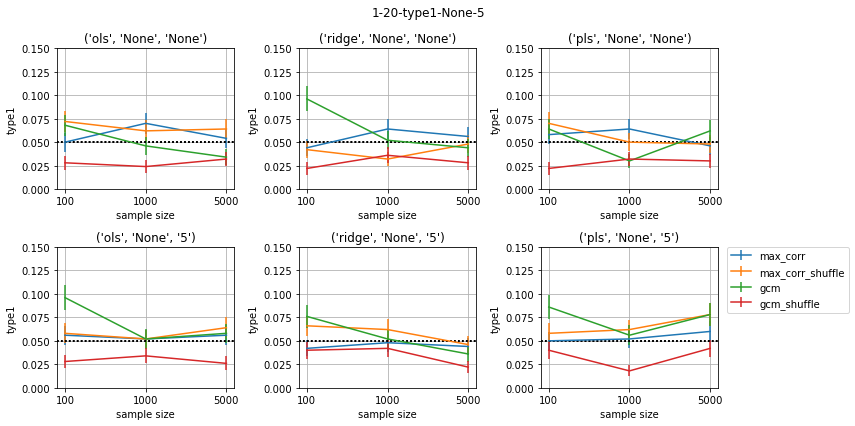

In [394]:
anyconfigurations = [] 
for dimxy in [1]:
    for dimz in [20]:
        for err_type in ['type1']:
            for z_int in ['None']:
                for n_conf in ['None',5]:
                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

#anyconfigurations
gen_plots_sample_size(anyconfigurations)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type2-None-None_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/1-20-type2-None-5_metrics.dat 


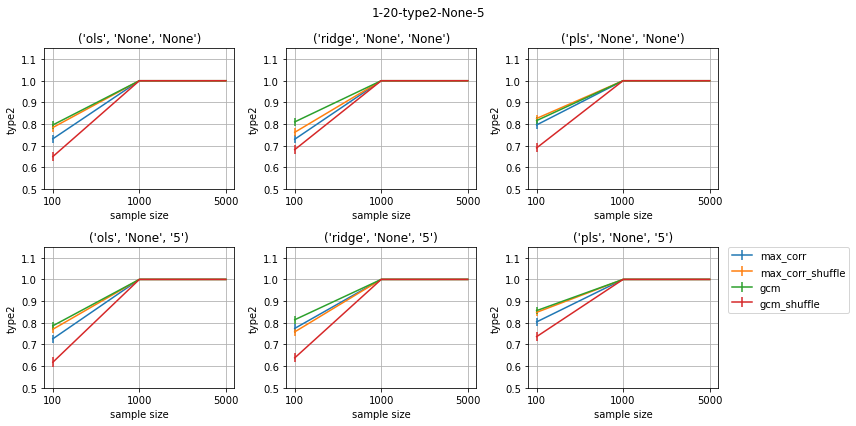

In [395]:
anyconfigurations = [] 
for dimxy in [1]:
    for dimz in [20]:
        for err_type in ['type2']:
            for z_int in ['None']:
                for n_conf in ['None',5]:
                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

#anyconfigurations
gen_plots_sample_size(anyconfigurations)

 # Plotting Cluster Results

In [104]:
if os.path.expanduser('~') == '/home/b/b381872':
    folder_name = os.path.expanduser('~') +'/work/bd1083/Interim_results/multCI/metrics/'
    save_folder = os.path.expanduser('~') + '/work/bd1083/Projects/multCI/figures/'
elif os.path.expanduser('~') == '/Users/urmininad':
    folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/cluster_results_renamed/'
    # folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/Interim_results/'
    # save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
    
def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    name_string = name_string[:-1]

    try:
        # print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        # print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

def get_results_from_para(para_setup):
    para_setup_str = tuple(para_setup.split("-"))
    # print('para_setup_str',para_setup_str)
    results = get_metrics_from_file(para_setup_str)
    return results  

In [105]:
para_setup = "5-20-type1-None-None-0.05-5000-ridge-max_corr_shuffle"#"5-1-type1-None-None-0.05-100-ols-max_corr-1"  #"50-20-type2-None-None-0.05-1000-pls-gcm_gmb-1"
get_results_from_para(para_setup)

{'rate_mean': 0.072, 'rate_error': 0.011117513211145737}

In [86]:
methods = ['max_corr', 'max_corr_shuffle', 'gcm_shuffle', 'gcm_gmb']
sample_range = [100,1000,5000]
reg_range = ['ols','ridge','pls']

In [87]:
def gen_plot_sample(dimxy,dimz,err_type,z_int,n_conf,alpha, n_components,paras = sample_range):
    

    fig, (axs) = plt.subplots(1, 3, figsize=(12,  4))
    axs = axs.ravel()
        
    for method in methods:
        
        for para in paras:
            
            para_plot = paras.index(para) + methods.index(method)/float(len(methods))*.6
                
            for i,reg in enumerate(reg_range):
                n_components = 1
                para_setup = (dimxy,dimz,err_type,z_int,n_conf,alpha,para,reg,method,n_components)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_results_from_para(para_setup)
                
                if metrics_dict == None:
                    n_components = 5
                    para_setup = (dimxy,dimz,err_type,z_int,n_conf,alpha,para,reg,method,n_components)
                    name = '%s-'*len(para_setup) % para_setup
                    para_setup = name[:-1]
                    metrics_dict = get_results_from_para(para_setup)
                
                if metrics_dict is not None:
                    
                    axs[i].errorbar(para_plot, metrics_dict['rate_mean'], 
                                    yerr = metrics_dict['rate_error'],label = method)
                    axs[i].set_xlabel('sample size')
                    axs[i].set_ylabel(err_type)                    
                    axs[i].set_xlim(-0.5, len(paras)) 
                    axs[i].set_title((reg,z_int,n_conf,n_components))
                
    for ax in axs:        
        ax.xaxis.set_ticks([paras.index(p) for p in paras] )
        ax.xaxis.set_ticklabels([str(p) for p in paras] )
        
        if err_type == 'type1':
            ax.set_ylim(0.0, 0.15)
            ax.axhline(alpha, color='grey', linewidth=2.)
        else:
            ax.set_ylim(0.5, 1.15) #(0.0, 0.15)
            
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    fig.tight_layout()
  
    

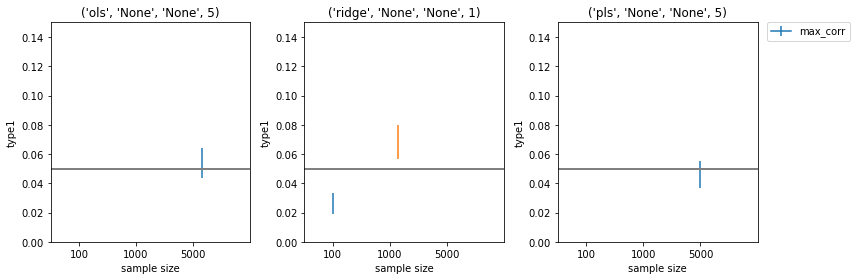

In [88]:
dimxy = 5
dimz = 20
err_type = 'type1'
z_int = 'None'
n_conf = 'None'
alpha = 0.05
n_components = 1

gen_plot_sample(dimxy,dimz,err_type,z_int,n_conf,alpha, n_components)

# Next Steps

##########################
 Ideas
##########################

(i) Idea 1: Focus on two simple multivariate configurations (n_compoents = 1), example below
(ii) Idea 2: Some results are already in cluster-results. Change mypath to cluster results in submit file :

    current_results_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    already_there = []
    configurations = []
    for conf in anyconfigurations:
        if conf not in configurations:
            # print (conf + '.dat')
            conf = conf.replace("'","")

            if (overwrite == False) and (conf + '.dat' in current_results_files):
                # print("Configuration %s already exists." % conf)
                already_there.append(conf)
                pass
            else:
                # print("Does not exist")
                configurations.append(conf)

            # print conf 


(iii) Idea 3: Make sure to count n_components 1 or 5 for OLS and ridge

(iv) Idea 4: Run the new submit script locally

##########################
 Concrete Steps
##########################
- Cluster results folder:
    - Delete the files where metric is none (see cell below)
    - Rename all the OLS and ridge cases with n_components 5 to n_components 1 (last arguement).
- Submit script:
    - change my path to local cluster results
    - change anyconfigurations, make simpler (see below)
    - Run locally 😬

In [106]:
anyconfigurations = []
for dimxy,dimz in [[5,20]]:#,[5,50]]:
        for err_type in ['type1', 'type2']:
            for z_int in ['None']:
                for n_conf in ['None',5]:
                    if type(n_conf)== str or dimz > n_conf:
                        for alpha in [0.05]:
                            for T in [100,1000,5000]:
                                for reg_type in ['ols','ridge']:
                                    for corr_type in ['max_corr','max_corr_shuffle','gcm_shuffle','gcm_gmb']:
                                        #for n_components in [1]:#,5]:
                                        para_setup = (dimxy,dimz,err_type,z_int,n_conf,alpha,T,reg_type,corr_type)
                                        name = '%s-'*len(para_setup) % para_setup
                                        name = name[:-1]
                                        anyconfigurations += [name]
                                            
len(anyconfigurations)
# anyconfigurations

96

In [107]:
# Tells you how many metric files from the list of anyconfigurations are None

l=0
for conf in anyconfigurations:
    metrics = get_results_from_para(conf)
    if metrics is None:
        l+=1
        #print(conf)
l

79

### Rename (Remove n_components suffix for non-PLS regression types) 

In [24]:
mypath = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/cluster_results_renamed/'

In [25]:
current_file_name = mypath+"test_3.rtf"
new_file_name = mypath+"test.rtf"

os.rename(current_file_name, new_file_name )

In [83]:
for file in os.listdir(mypath):
    
    filename = os.fsdecode(file)
    #print(filename)
    
    para_setup_str = tuple(filename.split("-"))
    # print(para_setup_str)
    
    #print(para_setup_str[-1].split("."))
    old_name = para_setup_str[-1].split(".")
    # print(old_name)
    #print(old_name[0].split("_"))
    
    if len(para_setup_str)>7:
        if para_setup_str[7] in ['ols', 'ridge']:
            if len(old_name)==3:
                print(old_name) 
                print(filename)
                
                
                
    
    # if len(old_name[0].split("_"))>1 and old_name[0].split("_")[1] == 'metrics':
    #     print('metrics file')
    
#     if para_setup_str[7] in ['ols', 'ridge']:
        
#         print('----------\n',para_setup_str[7],'REMOVE')
#         print('OLD NAME:',mypath+filename)
        
        
#         paras = [w.replace("'","") for w in para_setup_str]

#         dimxy = int(paras[0])
#         dimz = int(paras[1])
#         err_type = str(paras[2]) #'type1' or 'type2'
#         z_int = str(paras[3]) # None or 'low' or 'high'
#         n_conf = str(paras[4]) # None or an int less than dimz, indicates number of z components that act as confounder      
#         if n_conf == 'None':
#             n_conf  = 'None'
#         else:
#             n_conf = int(paras[4])
#         alpha =  float(paras[5])
#         sample_size = int(paras[6])
#         reg_type = str(paras[7])
#         corr_type = str(paras[8])
#         # n_components = int(paras[9]) # only relevant for PLS regression
        
#         para_setup = (dimxy,dimz,err_type,z_int,n_conf,alpha,T,reg_type,corr_type)
#         name = '%s-'*len(para_setup) % para_setup
#         name = name[:-1]
        
#         if len(old_name[0].split("_"))>1 and old_name[0].split("_")[1] == 'metrics':
#             name = name+'_metrics.dat'
#         else:
#             name = name+'.dat'
        
#         print('NEW NAME',mypath+name)
        
#         current_filename  = mypath+filename
#         new_filename = mypath+name
        
#         os.rename(current_filename, new_filename )
        
        #results = open(new_filename)

        
    #else:
        #print(para_setup_str[7],'KEEP')
    
    

# Archive

In [80]:
# OLD DATA GENERATION FOR CONFOUNDER

# def mult_data_conf(samples, dimxy, dimz, coef, z_int=None, num_int = None, n_conf = 'high', random_state = None):
    
#     if random_state is None:
#         seed = None
#         random_state = np.random.default_rng(seed=seed)
    
#     data = random_state.standard_normal((samples, 2*dimxy + dimz))
#     #print('1. data ',data.shape)
#     confounder = random_state.standard_normal((samples, 1))
#     #print('2. confounder',confounder.shape)
    
#     if z_int: #z_int denotes how dense z is internally connected (None implies unconnected)
        
#         if z_int == 'high': # z is fully connected 
            
#             data[:,int(2*dimxy):] += confounder
#             #print('3. data ',data.shape)
            
#         elif z_int == 'low': # num_int components of z are connected
            
#             if num_int == None:
#                 num_int = int(dimz/3)
                
#             data[:,int(2*dimxy):int(2*dimxy)+num_int] += confounder
#             #print('4. data ',data.shape)
        
#     if n_conf == 'high':
#         n_conf = dimz  # all components of z act as confounders
#     elif n_conf == 'low':
#         n_conf = int(dimz/3) # n_conf components of z act as confounders
    
#     data[:,0:dimxy] += data[:,int(2*dimxy):int(2*dimxy+n_conf)].mean(axis=1).reshape(samples, 1) # Z causes X
#     data[:,dimxy:int(2*dimxy)] += data[:,int(2*dimxy):int(2*dimxy)+n_conf].mean(axis=1).reshape(samples, 1) # Z causes Y
#     data[:,dimxy:int(2*dimxy)] += coef*data[:,0:dimxy] # X causes Y
    
#     return data

### Type 2

In [ ]:
dimxy = 5
dimz = 20
realizations = 500

sample_range = [100,1000,5000]
corr_type_range = ['max_corr','max_corr_shuffle','gcm_shuffle','gcm_gmb']
reg_range = ['ols','ridge','pls']

error = 'type2'

In [ ]:
metrics_5_20_type2 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, num_int = None, n_conf = None)

100 LinearRegression() max_corr
0.786 0.01781886360012894
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
0.742 0.019307503101126274
-----------------------
100 PLSRegression(n_components=1) max_corr
0.708 0.02027377064090446
-----------------------
100 LinearRegression() max_corr_shuffle
0.836 0.016961318816648658
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
0.858 0.015584185702179001
-----------------------
100 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.934 0.010941092450025239
-----------------------
100 LinearRegression() gcm_shuffle
0.916 0.012529708695735909
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
0.922 0.012366693171579854
-----------------------
100 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.964 0.00829001109770066
-----------------------
100 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.998 0.0020537487674981104
-----------------------
100 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
1000 LinearRegression() max_corr
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) max_corr
1.0 0.0
-----------------------
1000 LinearRegression() max_corr_shuffle
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

1.0 0.0
-----------------------
1000 LinearRegression() gcm_shuffle
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


1.0 0.0
-----------------------
1000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
5000 LinearRegression() max_corr
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
5000 PLSRegression(n_components=1) max_corr
1.0 0.0
-----------------------
5000 LinearRegression() max_corr_shuffle
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr_shuffle
1.0 0.0
-----------------------
5000 PLSRegression(n_components=1) max_corr_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

1.0 0.0
-----------------------
5000 LinearRegression() gcm_shuffle
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_shuffle
1.0 0.0
-----------------------
5000 PLSRegression(n_components=1) gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


1.0 0.0
-----------------------
5000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
5000 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
1.0 0.0
-----------------------
5000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
5000 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
5000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
5000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
5000 LinearRegression() gcm_shuffle


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

1.0 0.0
-----------------------
1000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
5000 LinearRegression() max_corr
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
5000 PLSRegression(n_components=1) max_corr
1.0 0.0
-----------------------
5000 LinearRegression() max_corr_shuffle
1.0 0.0
-----------------------
1000 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
5000 LinearRegression() max_corr
1.0 0.0
-----------------------
5000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
5000 PLSRegression(n_components=1) max_corr
1.0 0.0
---------

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/p

0.964 0.00829001109770066
-----------------------
100 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.998 0.0020537487674981104
-----------------------
100 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
1000 LinearRegression() max_corr
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
-----------------------
1000 PLSRegression(n_components=1) max_corr
1.0 0.0
-----------------------
1000 LinearRegression() max_corr_shuffle
0.964 0.00829001109770066
-----------------------
100 LinearRegression() gcm_gmb
1.0 0.0
-----------------------
100 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) gcm_gmb
0.998 0.0020537487674981104
-----------------------
100 PLSRegression(n_components=1) gcm_gmb
1.0 0.0
-----------------------
1000 LinearRegression() max_corr
1.0 0.0
-----------------------
1000 RidgeCV(alphas=array([ 0.1,  1. , 10. ])) max_corr
1.0 0.0
---------------

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached',


0.934 0.010941092450025239
-----------------------
100 LinearRegression() gcm_shuffle


### Dump Metrics

In [ ]:
#conf = "1-20-type1-None-None"
conf = "5-20-type2-None-None"
file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/%s' %(conf)

print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
#pickle.dump(metrics, file, protocol=-1)        
pickle.dump(metrics_5_20_type2, file, protocol=-1)        
file.close()

Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/5-20-type2-None-None_metrics.dat


In [ ]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/5-20-type2-None-None_metrics.dat 


In [431]:
anyconfigurations = [] 
for dimxy in [5,20,50]:
    for dimz in [1,20,50]:
        for err_type in ['type1', 'type2']:
            for z_int in ['None']:
                for n_conf in ['None',5]:
                    if type(n_conf)== str or dimz > n_conf:
                        for alpha in [0.05]:
                            for T in [100,1000,5000]:
                                for reg_type in ['ols','ridge','pls']:
                                    for corr_type in ['max_corr','max_corr_shuffle','gcm_shuffle','gcm_gmb']:
                                        for n_components in [1,5]:
                                            para_setup = (dimxy,dimz,err_type,z_int,n_conf,alpha,T,reg_type,corr_type,n_components)
                                            name = '%s-'*len(para_setup) % para_setup
                                            name = name[:-1]
                                            anyconfigurations += [name]
len(anyconfigurations                                                 )

2160

In [402]:
anyconfigurations = [] 
for dimxy in [5]:#,20,50]:
    for dimz in [1,20]:#,50]:
        for err_type in ['type1']:#, 'type2']:
            for z_int in ['None']:
                for n_conf in ['None',5]:
                    if type(n_conf)== str or dimz > n_conf:
                        for alpha in [0.05]:
                            for T in [100]:#,1000,5000]:
                                for reg_type in ['ols']:#,'ridge','pls']:
                                    for corr_type in ['max_corr']:#,'max_corr_shuffle','gcm_shuffle','gcm_gmb']:
                                        for n_components in [1]:#,5]:
                                            para_setup = (dimxy,dimz,err_type,z_int,n_conf,alpha,T,reg_type,corr_type,n_components)
                                            name = '%s-'*len(para_setup) % para_setup
                                            name = name[:-1]
                                            anyconfigurations += [name]


In [244]:
anyconfigurations = [] 
for dimxy in [5]:#,20,50]:
    for dimz in [1]:#,20,50]:
        for err_type in ['type1']:#, 'type2']:
            for z_int in ['None']:
                for n_conf in ['None']:#,5]:
                    if type(n_conf)== str or dimz > n_conf:
                        for alpha in [0.05]:
                            for T in [100]:#,1000,5000]:
                                for reg_type in ['ols','ridge','pls']:
                                    for corr_type in ['max_corr']:#,'max_corr_shuffle','gcm_shuffle','gcm_gmb']:
                                        for n_components in [1]:#,5]:
                                            para_setup = (dimxy,dimz,err_type,z_int,n_conf,alpha,T,reg_type,corr_type,n_components)
                                            name = '%s-'*len(para_setup) % para_setup
                                            name = name[:-1]
                                            anyconfigurations += [name]

In [245]:
len(anyconfigurations)

3

In [246]:
1+1

2

In [258]:
def _get_simplicial_node(circle_cpdag, variable_order):
        """Find simplicial nodes in circle component CPDAG.

        A vertex V is simplicial if all vertices adjacent to V are also adjacent
        to each other (form a clique).

        Parameters
        ----------
        circle_cpdag : array of shape (N, N, tau_max+1)
            Circle component of PCMCIplus graph.
        variable_order : list of length N
            Order of variables in which to search for simplicial nodes.

        Returns
        -------
        (j, adj_j) or None
            First found simplicial node and its adjacencies.
        """

        for j in variable_order:
            
            print('j',j)
            adj_j = np.where(np.logical_or(circle_cpdag[:,j,0] == "o-o",
                                           circle_cpdag[:,j,0] == "o?o"))[0].tolist()

            # Make sure the node has any adjacencies
            all_adjacent = len(adj_j) > 0
            
            print('all_adjacent', all_adjacent)

            # If it has just one adjacency, it's also simplicial
            if len(adj_j) == 1:
                return (j, adj_j)  
            else:
                for (var1, var2) in itertools.combinations(adj_j, 2):
                    if circle_cpdag[var1, var2, 0] == "": 
                        all_adjacent = False
                        break

                if all_adjacent:
                    return (j, adj_j)
                

        return None

def _get_dag_from_cpdag(cpdag_graph, variable_order):
    """Yields one member of the Markov equivalence class of a CPDAG.

    Parameters
    ----------
    cpdag_graph : array of shape (N, N, tau_max+1)
        Result of PCMCIplus, a CPDAG.
    variable_order : list of length N
        Order of variables in which to search for simplicial nodes.

    Returns
    -------
    dag : array of shape (N, N, tau_max+1)
        One member of the Markov equivalence class of the CPDAG.
    """

    # TODO: Check whether CPDAG is chordal

    # Initialize resulting MAG
    dag = np.copy(cpdag_graph)
    
    print('dag copy', dag)

    # Turn circle component CPDAG^C into a DAG with no unshielded colliders.
    circle_cpdag = np.copy(cpdag_graph)
    # All lagged links are directed by time, remove them here
    circle_cpdag[:,:,1:] = ""
    # Also remove conflicting links
    circle_cpdag[circle_cpdag=="x-x"] = ""
    # Find undirected links, remove directed links
    for i, j, tau in zip(*np.where(circle_cpdag != "")):
        if circle_cpdag[i,j,0][1] == '?':
            raise ValueError("Invalid middle mark.")
        if circle_cpdag[i,j,0] == "-->":
            circle_cpdag[i,j,0] = ""
            
    print('executing simplical nodes')

    # Iterate through simplicial nodes
    simplicial_node = _get_simplicial_node(circle_cpdag,
                                                variable_order)
    print("simplical_nodes", simplicial_node)
    # 
    while simplicial_node is not None:
        
        # print("YYYYYY")

        # Choose such a vertex V1 and orient any edges incident to V1 into
        # V1 in the MAG And remove V1 and these edges from the circle
        # component PAG
        (j, adj_j) = simplicial_node
        for var in adj_j:
            dag[var, j, 0] = "-->"
            dag[j, var, 0] = "<--"
            circle_cpdag[var, j, 0] = circle_cpdag[j, var, 0] = "" 

        # Iterate
        simplicial_node = _get_simplicial_node(circle_cpdag,
                                                variable_order)

    return dag


In [263]:
def pc_alg(data_agg, vector_vars = None,
           pc_alpha = 0.05, verbosity = 0,cr = True):
    
    # PC-alg on aggregated data

    #T, N = data_agg.shape
    
    if vector_vars ==None:
        dataframe = pp.DataFrame(data_agg, analysis_mode = 'single')
        parcorr = ParCorr(significance='analytic')
        ci_test = parcorr
        
    else: 
        dataframe  =  pp.DataFrame(data_agg, vector_vars = vector_vars, analysis_mode = 'single')
        parcorr_mult = ParCorrMult(significance='analytic')
        ci_test = parcorr_mult   

    pcmci = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=ci_test,
        verbosity=verbosity)

    results = pcmci.run_pcalg(tau_max=0, pc_alpha=pc_alpha, conflict_resolution=cr)
    p_matrix = results['p_matrix']
    sepsets = results['sepsets']
    graph = results['graph']
    val_matrix = results['val_matrix']
    variable_order = np.argsort(np.abs(val_matrix).sum(axis=(0,2)))[::-1]
    print(variable_order)
    
    # for j in variable_order:
    #     print('j in pc',j)
    
#     pcmci_base = PCMCIbase(
#         dataframe=dataframe, 
#         cond_ind_test=ci_test,
#         verbosity=verbosity)
    dag = _get_dag_from_cpdag(graph, variable_order)
    
    return p_matrix,graph,dag

In [270]:
seed = 41
np.random.seed(seed)     # Fix random seed
def lin_f(x): return x



links_coeffs_1 = {0: [],
                1: [],
                2: [((0, 0), 0.1, lin_f), ((1, 0), -0.5, lin_f)],
                3: [((0, 0), 0.1, lin_f), ((1, 0), -0.5, lin_f)],
                }

links_coeffs_2 = {0: [((1, 0), -0.8, lin_f)],
                1: [((3, 0), 0.8, lin_f)],
                2: [((1, 0), 0.5, lin_f), ((3, 0), 0.6, lin_f)],
                3: [],
                }

links_coeffs = links_coeffs_1

T = 200     # time series length
data, _ = toys.structural_causal_process(links_coeffs, T=T, seed=seed)
T, N = data.shape

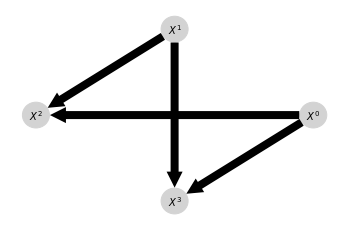

In [271]:
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
true_graph = toys.links_to_graph(links_coeffs)
ext_summ_lag = 2

tp.plot_graph(
    graph=true_graph,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

In [272]:
pmat,pred_graph,dag = pc_alg(data,# vector_vars = vector_vars,
           pc_alpha = 0.01)

[1 3 2 0]
dag copy [[['']
  ['']
  ['']
  ['']]

 [['']
  ['']
  ['o-o']
  ['o-o']]

 [['']
  ['o-o']
  ['']
  ['']]

 [['']
  ['o-o']
  ['']
  ['']]]
executing simplical nodes
j 1
all_adjacent True
j 3
all_adjacent True
simplical_nodes (3, [1])
j 1
all_adjacent True
j 1
all_adjacent False
j 3
all_adjacent False
j 2
all_adjacent False
j 0
all_adjacent False


In [273]:
pred_graph[:,:,0]

array([['', '', '', ''],
       ['', '', 'o-o', 'o-o'],
       ['', 'o-o', '', ''],
       ['', 'o-o', '', '']], dtype='<U3')

In [274]:
dag

array([[[''],
        [''],
        [''],
        ['']],

       [[''],
        [''],
        ['<--'],
        ['-->']],

       [[''],
        ['-->'],
        [''],
        ['']],

       [[''],
        ['<--'],
        [''],
        ['']]], dtype='<U3')

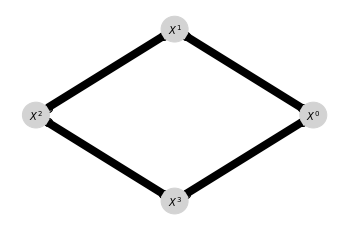

In [269]:

tp.plot_graph(
    graph=pred_graph,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

In [202]:
def shd(graph_true, graph_pred, double_for_anticausal = True):
    
    links_true= graph_to_dict(graph_true)
    links_pred= graph_to_dict(graph_pred)
    
    #print(links_true, links_pred)

    adj_true = links_to_binary_graph(links_true)[:,:,0]
    adj_pred = links_to_binary_graph(links_pred)[:,:,0]
    
    #print(adj_true, adj_pred)
    
    diff = np.abs(adj_true - adj_pred)
    
    #print(diff)
    if double_for_anticausal:
        return np.sum(diff)
    else:
        diff = diff + diff.transpose()
        diff[diff > 1] = 1  # Ignoring the double edges.
        return np.sum(diff)/2

In [320]:
def vectorize_to_fine(N_fine, N_array, partition = 'mild'):
    
    tot_fine  = len(N_fine)
    tot_coarse = len(N_array)
    
    if partition == 'mild':
        # Only first vec_var gets paritioned 
        N_new = [tot_fine-tot_coarse+1]+[1]*(tot_coarse-1)
        print(N_new)
    elif partition == 'medium':
        # first half vec_vars get partitioned
        N_new = [tot_fine-int(tot_coarse/2)]+[1]*(int(tot_coarse/2))
        print(N_new)
    
    vector_vars = {}
    N = len(N_new)
    l=0
    for i in range(N):
        j = N_new[i]
        for k in range(j):
            if k==0:
                vector_vars[i] = [(k+l,0)] 
            else:
                vector_vars[i].append((k+l,0)) 
        l+=j

    return vector_vars

In [322]:
N_array = [50]*5
N_fine = [10]*5 + [50]*4
vectorize_to_fine(N_fine,N_array)

[5, 1, 1, 1, 1]


{0: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)],
 1: [(5, 0)],
 2: [(6, 0)],
 3: [(7, 0)],
 4: [(8, 0)]}

In [321]:
N_array = [50]*5
N_fine = [25]*6 + [50]*2

vectorize_to_fine(N_fine,N_array,partition='medium')

[6, 1, 1]


{0: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0)], 1: [(6, 0)], 2: [(7, 0)]}

In [313]:
N_array

[50, 50, 50, 50, 50]

In [317]:
n=5
[int(1.5*(min(N_array)))]*int(1.5*n) + list(np.zeros(math.comb(n,2)-int(1.5*n), dtype = int))

[75, 75, 75, 75, 75, 75, 75, 0, 0, 0]

In [318]:
[int(min(N_array))]* (n) + list(np.zeros(math.comb(n,2)-n, dtype = int))

[50, 50, 50, 50, 50, 0, 0, 0, 0, 0]

In [319]:
[int(min(N_array))]*n

[50, 50, 50, 50, 50]

In [103]:
seed = 42
np.random.seed(seed)     # Fix random seed
def lin_f(x): return x



links_coeffs_1 = {0: [],
                1: [],
                2: [((0, 0), 0.1, lin_f), ((1, 0), -0.5, lin_f)],
                3: [((0, 0), 0.1, lin_f), ((1, 0), -0.5, lin_f)],
                }

links_coeffs = links_coeffs_1

T = 200     # time series length
data, _ = toys.structural_causal_process(links_coeffs, T=T, seed=seed)
T, N = data.shape

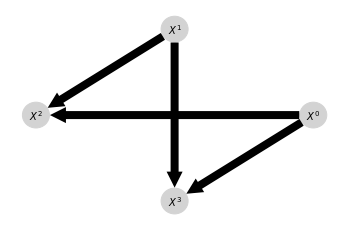

In [104]:
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
true_graph = toys.links_to_graph(links_coeffs)
ext_summ_lag = 2

tp.plot_graph(
    graph=true_graph,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

In [105]:
true_graph[:,:,0]

array([['', '', '-->', '-->'],
       ['', '', '-->', '-->'],
       ['<--', '<--', '', ''],
       ['<--', '<--', '', '']], dtype='<U3')

In [110]:
pmat,pred_graph,dag = pc_alg(data,# vector_vars = vector_vars,
           pc_alpha = 0.01)

In [111]:
pred_graph[:,:,0]

array([['', '', '', ''],
       ['', '', 'o-o', 'o-o'],
       ['', 'o-o', '', ''],
       ['', 'o-o', '', '']], dtype='<U3')

In [109]:
N,N,tau_max = np.shape(true_graph)
n_realizations = 1

contemp_cross_mask_tril = np.zeros((N,N,tau_max + 1)).astype('bool')
contemp_cross_mask_tril[:,:,0] = np.tril(np.ones((N, N)), k=-1).astype('bool')
any_mask = np.ones((N,N,tau_max + 1)).astype('bool')
any_mask[:,:,0] = contemp_cross_mask_tril[:,:,0]
any_mask = np.repeat(any_mask.reshape(1, N,N,tau_max + 1), n_realizations, axis=0)

In [112]:
fpr = (((true_graph=="")*(pred_graph!="")*any_mask).sum(axis=(1,2,3)),((true_graph=="")*any_mask).sum(axis=(1,2,3)) )

In [113]:
fpr

(array([0]), array([10]))

In [144]:
n = 500
x = np.random.normal(size=(n,2))
z = np.random.normal(size=(n,2)) 

In [146]:
reg = LR().fit(z, x)

In [150]:
reg.coef_.shape

(2, 2)

In [160]:
A = np.ones((2,2))
A[1,1] = 2
A[0,1] = 3
A[1,0] = 4
A

array([[1., 3.],
       [4., 2.]])

In [162]:
np.tile(A, 2).flatten('F') 

array([1., 4., 3., 2., 1., 4., 3., 2.])

In [163]:
np.tile(A, 2).flatten('F')*np.tile(A, 2).flatten('F')

array([ 1., 16.,  9.,  4.,  1., 16.,  9.,  4.])

In [172]:
dimx = 3
dimy = 2
dimz = 1

vector_vars={0:[(i,0) for i in range(dimx)], 
            1:[(j,0) for j in range(dimx, dimx+dimy)], 
            2:[(k, 0) for k in range(dimx+dimy, dimx+dimy+dimz)]}
            

In [173]:
vector_vars

{0: [(0, 0), (1, 0), (2, 0)], 1: [(3, 0), (4, 0)], 2: [(5, 0)]}

In [102]:
socket.gethostname()

'MacBook-Pro-70.fritz.box'

In [8]:
print(os.path.expanduser('~'))

/Users/urmininad


In [10]:
path = "/Users/urmininad/Downloads/graph-clustering-main/average_basins_jan20"

In [103]:
def split(a, n):
    k, m = len(a) // n, len(a) % n
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [108]:
metrics = {}
metrics['a'] = 1
metrics['b'] = 2
metrics

{'a': 1, 'b': 2}

In [110]:
__name__

'__main__'

In [113]:
anyconfigurations = []
for group_size in [5,10,20,50]:
    for n_vars in [5]:
        for min_coeff in [0.1]:
            for max_coeff in [0.4]:
                for step_size in [0.1]:
                    for T in [5000]:
                        for ci_test in ['parcorr_maxcorr']:
                            for method in ['ind', 'comm']:
                                for coeff_range in ['neg']:
                                    para_setup = (group_size,n_vars,min_coeff,max_coeff,step_size,T,ci_test,method,coeff_range)
                                    name = '%s-'*len(para_setup) % para_setup
                                    name = name[:-1]
                                    anyconfigurations += [name]

In [116]:
anyconfigurations

['5-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg',
 '5-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg',
 '10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg',
 '10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg',
 '20-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg',
 '20-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg',
 '50-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg',
 '50-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg']

In [13]:
#df = pd.read_csv(path + "/" + str(basin_id) + ".csv", index_col=None, header=0)

df = pd.read_csv(path + "/" + str(6112080) + ".csv", index_col=None, header=0)
#low_alt_df[basin_id] = df
df

,time,tavg,tmin,tmax,prec,rad,Qobs,QsimGlobal,snowpackGlobal,SWC005Global,SMGlobal,ETGlobal
0,1950-01-01,6.768371,-0.048717,10.936914,0.000000,96.392719,NaN,20.969887,9.753825,12.965311,0.378235,0.209348
1,1950-01-02,5.484359,-0.643772,12.224272,0.000000,88.605993,NaN,38.830873,1.921303,17.711939,0.386226,0.302967
2,1950-01-03,5.957487,-0.056383,14.182935,0.000000,54.076826,NaN,36.536023,0.084519,18.465156,0.387818,0.335376
3,1950-01-04,7.434952,-0.202929,13.058127,0.000000,89.145640,NaN,35.583011,0.004416,18.294063,0.387542,0.342736
4,1950-01-05,3.418268,-2.306931,8.039191,0.000000,82.293310,NaN,34.781225,0.000074,18.109277,0.387228,0.254296
...,...,...,...,...,...,...,...,...,...,...,...,...
26293,2021-12-27,11.878844,11.022940,13.578539,0.001566,46.393478,NaN,11.992530,0.000000,26.511004,0.896269,0.440263
26294,2021-12-28,11.700072,9.712649,14.686258,0.137810,55.826778,NaN,10.597576,0.000000,26.402728,0.895887,0.556386
26295,2021-12-29,11.716027,8.695741,15.415807,0.492980,50.026909,NaN,10.273775,0.000000,26.272482,0.895481,0.696013
26296,2021-12-30,10.929093,5.808594,14.511323,0.000000,82.616691,NaN,9.769247,0.000000,26.119893,0.894965,0.707387


In [16]:
#df_basin = df[['tg', 'rr', 'runoff_mean']].dropna()
df_basin = df[['time']].dropna()
df_basin

,time
0,1950-01-01
1,1950-01-02
2,1950-01-03
3,1950-01-04
4,1950-01-05
...,...
26293,2021-12-27
26294,2021-12-28
26295,2021-12-29
26296,2021-12-30


In [64]:
min_coeff = 0.3
max_coeff = 0.5
step_size = 0.1
coupling_coeffs = list(np.arange(min_coeff, max_coeff+0.1, step_size))
coupling_coeffs

[0.3, 0.4, 0.5]

In [73]:
nn =10
nsim = 5
noise = np.random.randn(nn, nsim)
noise#.shape

array([[-0.93537859, -0.57657414, -0.52684983,  0.38709515, -0.16462981],
       [-2.40912317,  0.47779578,  1.14948932, -0.26876616,  1.07507679],
       [-0.13422922, -0.88496028,  2.01981278, -0.89131322, -0.4076052 ],
       [-0.91265321,  0.50993625,  0.04642046,  0.6685003 , -0.31349298],
       [-0.02632237,  0.66558864, -0.71845961, -0.17035808,  0.4400454 ],
       [ 0.32681445, -0.90118944,  0.55573771, -0.31221105, -2.05218802],
       [-0.80640046,  0.23970856,  0.79286103, -0.03040395,  1.14574844],
       [ 0.67438215, -0.91236252,  1.24531766, -1.9379732 ,  0.61625962],
       [ 2.07127954, -0.61609428, -2.11831422, -1.21858132,  0.63249099],
       [ 1.88395901, -0.03635265,  0.67865961,  0.94019161, -0.18227771]])

In [74]:
R_mat = np.ones((5,10))
test_stat_sim = np.abs(R_mat @ noise)

In [82]:
anyconfigurations = []
for model in ['random_lineargaussian']:#, 'random_linearmixed']:  

  for N in [5]:#[2, 3, 5, 10, 20]:
    if N == 2:
        n_links = 1
    else:
        if 'fixeddensity' in model:
            n_links = max(N, int(0.2*N*(N-1.)/2.)) 
        elif 'highdegree' in model:
            n_links = int(1.5*N)   
        else:
            n_links = N

    for coeff in [0.5]:
        for auto in [0.3]:#[0., 0.2, 0.4, 0.5, 0.9, 0.95, 0.98, 0.99, 0.999]:  
            for contemp_fraction in [0.0]: 
                for tau_max in [5]:#[1, 5, 10, 15, 20, 25]:
                    for T in [100]:
                        for ci_test in ['par_corr']: # ['oracle']
                            method_list = ['pcmci_full_simple']#,'pcmci_full_bonferroni','pcmci_ext'] #'pcmci_full']
                            for method in method_list: #, 'ground_truth' ]:
                                for pc_alpha in [0.01]:#, 0.05]: #, 0.1]: 
                                    para_setup = (model, N, n_links, coeff, auto, contemp_fraction, tau_max, T, ci_test, method, pc_alpha)
                                    name = '%s-'*len(para_setup) % para_setup
                                    name = name[:-1]
                                    anyconfigurations += [name]

In [86]:
anyconfigurations

['random_lineargaussian-5-5-0.5-0.3-0.0-5-100-par_corr-pcmci_full_simple-0.01']

In [88]:
newli = anyconfigurations[0].split('-')

In [89]:
newli

['random_lineargaussian',
 '5',
 '5',
 '0.5',
 '0.3',
 '0.0',
 '5',
 '100',
 'par_corr',
 'pcmci_full_simple',
 '0.01']

In [96]:
if 56.0%2.0:
    print('odd')
else:
    print('even')

even


In [100]:
int(55/2)

27

In [99]:
55/2

27.5